# Creating the External Forcing Conditions

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Defining the input directory. This directory also contains the bathymetry and initial condition files.

In [2]:
# define the input directory
input_dir = '/Users/sofia/Documents/CS185C/project/input'

### Downloading the ECCO external forcing fields

I downloaded the ATEMP, AQH, SWDOWN, LWDOWN, UWIND, VWIND, and PRECIP ECCO external forcing fields for the year 2008 and stored them in my data directory.

In [3]:
data_folder = '/Users/sofia/Documents/CS185C/project/data'

### Reading in the external forcing fields

Using th `exf` module from the `eccoseas` package, I will read in the ECCO fields.

In [4]:
from eccoseas.ecco import exf

In [5]:
# make a file dictionary to loop over
file_prefix_dict = {'ATEMP':'EIG_tmp2m_degC_plus_ECCO_v4r1_ctrl',
             'AQH':'EIG_spfh2m_plus_ECCO_v4r1_ctrl',
             'SWDOWN':'EIG_dsw_plus_ECCO_v4r1_ctrl',
             'LWDOWN':'EIG_dlw_plus_ECCO_v4r1_ctrl',
             'UWIND':'EIG_u10m',
             'VWIND':'EIG_v10m',
             'PRECIP':'EIG_rain_plus_ECCO_v4r1_ctrl'}

# short list for testing
variable_names = ['ATEMP']

# full list - uncomment after testing
variable_names = list(file_prefix_dict.keys())

In [6]:
# make a list to hold all of the exf grid
exf_grids = []
year=2008

# loop through each variable to read in the grid
for field in variable_names:
    exf_lon, exf_lat, exf_grid = exf.read_ecco_exf_file(data_folder, file_prefix_dict[field], year)
    exf_grids.append(exf_grid)

In [ ]:
Exf_Lon, Exf_Lat = np.meshgrid(exf_lon, exf_lat)
ecco_points = np.column_stack([Exf_Lon.ravel(), Exf_Lat.ravel()])

Creating a mask for interpolation:

In [8]:
ecco_mask = np.ones((np.size(Exf_Lon),))

### Reading in the Model Grid

In this step I will need to recreate my model grid and read in the bathymetry file.

In [9]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/16
xgOrigin = -75
ygOrigin = 26
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'EastCoast_bathymetry.bin'),'>f4').reshape(np.shape(XC))

Creating a mask for interpolation using the `hFac` module from the `eccoseas` package:

In [10]:
from eccoseas.downscale import hFac

In [11]:
surface_mask = hFac.create_surface_hFacC_grid(bathy, delR=1)

Plotting the bathymetry to observe the mask.

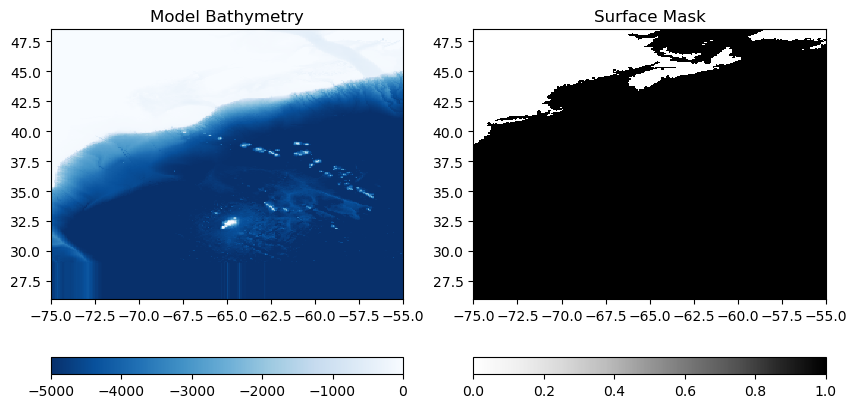

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, surface_mask, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Surface Mask')

plt.show()

### Interpolating the Fields onto the Model Grid
Using the `horizontal` module from the `eccoseas` package, I will interpolate the ECCO external forcing fields onto my model grid.

In [13]:
from eccoseas.downscale import horizontal

In [14]:
# ensure the output folder exists
if 'exf' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir, 'exf'))

In [15]:
# loop through each variable and corresponding ECCO grid
for variable_name, exf_grid in zip(variable_names, exf_grids):

    # print a message to keep track of which variable we are working on
    print('    - Interpolating the '+variable_name+' grid')

    # create a grid of zeros to fill in
    interpolated_grid = np.zeros((np.shape(exf_grid)[0], np.shape(XC)[0], np.shape(XC)[1]))

    # loop through each timestep to generate the interpolated grid
    for timestep in range(np.shape(exf_grid)[0]): # uncomment for testing

        # print a message every 100 timesteps to show where we are in the stack
        # uncomment to use
        if timestep%100==0:
            print('        - Working on timestep '+str(timestep)+' of '+str(np.shape(interpolated_grid)[0]))

        # grab the values for this timestep and run the interpolation function
        ecco_values = exf_grid[timestep, :, :].ravel()
        interp_timestep = horizontal.downscale_2D_points_with_zeros(ecco_points, ecco_values, ecco_mask,
                                                                    XC, YC, surface_mask)
        interpolated_grid[timestep,:,:] = interp_timestep

    # convert ECCO values to MITgcm defaults
    if variable_name=='ATEMP':
        interpolated_grid += 273.15
    if variable_name in ['SWDOWN','LWDOWN']:
        interpolated_grid *=-1

    # output the interpolated grid
    output_file = os.path.join(input_dir,'exf',variable_name+'_'+str(year))
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

    - Interpolating the ATEMP grid
        - Working on timestep 0 of 1464
        - Working on timestep 100 of 1464
        - Working on timestep 200 of 1464
        - Working on timestep 300 of 1464
        - Working on timestep 400 of 1464
        - Working on timestep 500 of 1464
        - Working on timestep 600 of 1464
        - Working on timestep 700 of 1464
        - Working on timestep 800 of 1464
        - Working on timestep 900 of 1464
        - Working on timestep 1000 of 1464
        - Working on timestep 1100 of 1464
        - Working on timestep 1200 of 1464
        - Working on timestep 1300 of 1464
        - Working on timestep 1400 of 1464
    - Interpolating the AQH grid
        - Working on timestep 0 of 1464
        - Working on timestep 100 of 1464
        - Working on timestep 200 of 1464
        - Working on timestep 300 of 1464
        - Working on timestep 400 of 1464
        - Working on timestep 500 of 1464
        - Working on timestep 600 of 1464
       

### Plotting the External Forcing Fields

In [17]:
meta_dict = {'ATEMP':[270, 300, cm.thermal, '$^{\circ}$C'],
             'AQH':[0, 0.025, cm.tempo, 'kg/kg'],
             'PRECIP':[0, 1e-7, cm.tempo, 'm/s'],
             'SWDOWN':[-10,2,cm.solar,'W/m$^2$'],
             'LWDOWN':[-50, 550,cm.solar,'W/m$^2$'],
             'UWIND':[-20, 20, cm.balance, 'm/s'],
             'VWIND':[-20, 20, cm.balance, 'm/s'],
             'RUNOFF':[0, 2e-8, cm.tempo, 'm/s']}

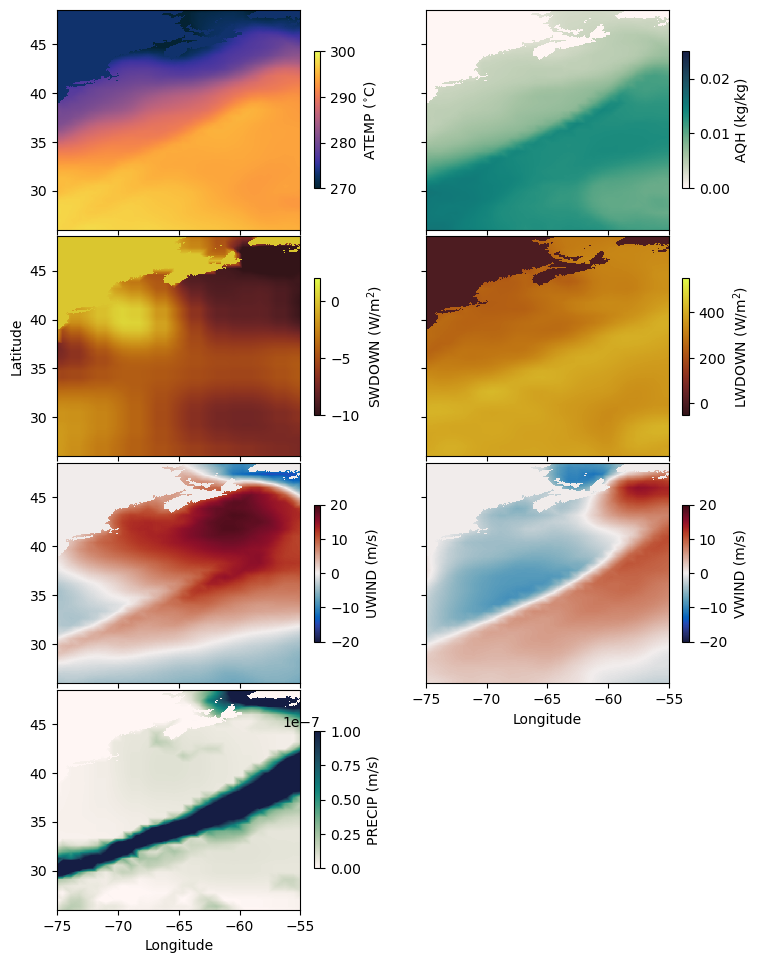

In [18]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(4, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    EastCoast_exf_grid = np.fromfile(os.path.join(input_dir,'exf',variable_name+'_'+str(year)),'>f4')
    EastCoast_exf_grid = EastCoast_exf_grid.reshape((np.shape(exf_grid)[0],np.shape(XC)[0], np.shape(XC)[1]))

    # choose just the first timestep for plotting
    EastCoast_exf_grid = EastCoast_exf_grid[0, :, :]
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(XC, YC, EastCoast_exf_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()